This is a simple prediction to understand the relationship between rainfall and reservoir fill rates for a given year.

Specifically, we use:
- Outcome: Difference in fill rate year-over-year
- Predictor: Relative rainfall (100% = historical average)

By predicting the fill rate from the rain, we can make counterfactual estimates of fill rates depending on the relative rainfall in a year.

# Setup

In [2]:
# type: ignore

import requests
import numpy as np
import os
import django
import pandas as pd 

import statsmodels.formula.api as smf

os.environ.setdefault("DB_USED", "rdstunnel")
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "water.settings.dev")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
_ = django.setup()

from water.utils import data
from water.models import ReservoirState, Reservoir, ReservoirStateSerializer, RainFall

# Loading the data

In [3]:
num_obs = 10000

start_date = '2011-01-01'
end_date = '2023-01-10'
is_first_of_year = True

reservoir_uuids = [str(reservoir.uuid) for reservoir in Reservoir.objects.all()]

args = {
    'num_obs': num_obs,
    'start_date': start_date,
    'end_date': end_date,
    'is_first_of_year': is_first_of_year,
    'reservoir_uuids': reservoir_uuids
}

res = data.get_wide_data(**args)
df = pd.DataFrame(res)

Getting wide data
Getting states


# Data preparation

In [4]:
rainfall_fields = RainFall._meta.get_fields()
for field in rainfall_fields:
    df[field.name] = df['rainfall'].apply(lambda x: getattr(x, field.name))
    
reservoir_state_fields = ReservoirState._meta.get_fields()
for field in reservoir_state_fields:
    df[field.name] = df['reservoir_state'].apply(lambda x: getattr(x, field.name))
    
reservoir_fields = Reservoir._meta.get_fields()
for field in reservoir_fields:
    df[field.name] = df['reservoir'].apply(lambda x: getattr(x, field.name))

df = df.sort_values(['name', 'date'])  

# Analysis

In [5]:
df['rainfall_rel'] = df.amount_cumulative / df.amount_cumulative_historical
df['volume_lag'] = df.groupby('name').volume.shift()
df['volume_diff'] = df.volume - df.volume_lag
df['volume_diff_rel'] = df.volume_diff / df.capacity

<Axes: xlabel='rainfall_rel', ylabel='volume_diff_rel'>

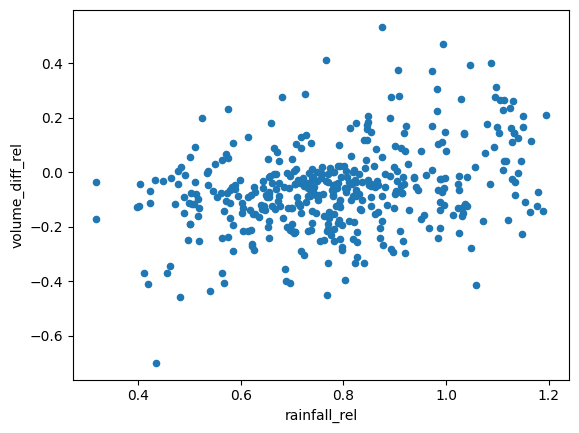

In [6]:
(df
 .query('0.3 <= rainfall_rel <= 1.2')
 [['rainfall_rel', 'volume_diff_rel']]
 .plot.scatter(x='rainfall_rel', y='volume_diff_rel'))

## Regression

The simple regressions give us a result of 

```
volume_diff_rel = -0.3 + 0.3 * rainfall_rel
```

We can also think of this as follows: 
- If rainfall were 100%, then the volume would stay constant.
- If rainfall is 0%, volume would go down by 30%

This informs the simple prediction at https://water.chrisgoldammer.com/shortfall

In [7]:
df_reg = df.copy()

form = 'volume_diff_rel ~ rainfall_rel'
model = smf.ols(formula=form, data=df_reg).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        volume_diff_rel   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     214.5
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           1.38e-40
Time:                        18:43:12   Log-Likelihood:                 223.71
No. Observations:                 495   AIC:                            -443.4
Df Residuals:                     493   BIC:                            -435.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2953      0.020    -14.760   

In [8]:
coef = model.params['rainfall_rel']
coef

0.30850317449590436